## 1.Chest X-rays(indiana university) 분석하기
## 1-1. projection파일과 reports 파일을 이용하여 분석해보았습니다

In [11]:
import pandas as pd

# Load the uploaded CSV files
file_path_projections = 'C:/Users/PC/OneDrive - gachon.ac.kr/바탕 화면/archive/indiana_projections.csv'
file_path_reports = 'C:/Users/PC/OneDrive - gachon.ac.kr/바탕 화면/archive/indiana_reports.csv'

# Read the CSV files
projections_df = pd.read_csv(file_path_projections)
reports_df = pd.read_csv(file_path_reports)


# Display the first few rows of each dataset to understand their structure
projections_df.head(), reports_df.head()


(   uid                filename projection
 0    1  1_IM-0001-4001.dcm.png    Frontal
 1    1  1_IM-0001-3001.dcm.png    Lateral
 2    2  2_IM-0652-1001.dcm.png    Frontal
 3    2  2_IM-0652-2001.dcm.png    Lateral
 4    3  3_IM-1384-1001.dcm.png    Frontal,
    uid                                               MeSH  \
 0    1                                             normal   
 1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
 2    3                                             normal   
 3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
 4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   
 
                                             Problems  \
 0                                             normal   
 1                      Cardiomegaly;Pulmonary Artery   
 2                                             normal   
 3  Pulmonary Disease, Chronic Obstructive;Bullous...   
 4                         Osteophyte;Thickening;Lung   
 
                       

--------------------------------------------------------------------------------------------
#### 1-2. 두개의 데이터 프레임을 하나의 데이터 프레임(merge_df)로 합침(uid항목을 공통항목으로 지정함)
####      - Frontal과 Lateral의 분포, 주요 진단(Problems)별 빈도를 통계를 냄
####      -Frontal과 Lateral 이미지에서 발견된 문제의 차이점을 분석함

In [6]:
# Merge the datasets on 'uid'
merged_df = pd.merge(projections_df, reports_df, on='uid')

# Summary statistics for projection types
projection_counts = merged_df['projection'].value_counts()

# Analyze the frequency of different problems in 'Problems' column
problems_counts = merged_df['Problems'].str.split(';').explode().value_counts()

# Compare Problems by projection type
problems_by_projection = merged_df.groupby('projection')['Problems'].apply(
    lambda x: x.str.split(';').explode().value_counts()
)

projection_counts, problems_counts.head(), problems_by_projection


(projection
 Frontal    3818
 Lateral    3648
 Name: count, dtype: int64,
 Problems
 normal                   2695
 Lung                     1083
 Opacity                   988
 Cardiomegaly              655
 Pulmonary Atelectasis     645
 Name: count, dtype: int64,
 projection                       
 Frontal     normal                   1387
             Lung                      545
             Opacity                   501
             Calcinosis                332
             Cardiomegaly              331
                                      ... 
 Lateral     Thoracic vertebrae          1
             Bronchitis                  1
             Trachea, Carina             1
             Colonic Interposition       1
             Hemothorax                  1
 Name: Problems, Length: 239, dtype: int64)

---------------------------------------------------------
# 분석결과:

## 투영 방식별 분포:

#### Frontal 이미지: 3818개
#### Lateral 이미지: 3648개
#### 발견된 주요 문제(Problems):

#### normal: 2695건
#### Lung: 1083건
#### Opacity: 988건
#### Cardiomegaly: 655건
#### Pulmonary Atelectasis: 645건
#### 투영 방식에 따른 문제 분포:

#### Frontal 이미지에서는 normal, Lung, Opacity가 주요 문제.
#### Lateral 이미지에서도 유사한 문제 분포를 보임.(각각 1번 분포함)

-----------------------------------------------------------------------------------------------------------

## 1-3.문제(Problems)와 투영 방식 간의 분포 시각화:
#### 투영 방식(Frontal, Lateral)에 따른 주요 문제의 빈도를 시각화

## 문제 상관관계 분석:
#### 자주 함께 발견되는 문제들을 분석하여 상관관계를 시각화.

## 최종 진단(Impression) 빈도 분석 및 시각화:
#### 최종 진단의 상위 빈도를 시각화.

<Figure size 1200x600 with 0 Axes>

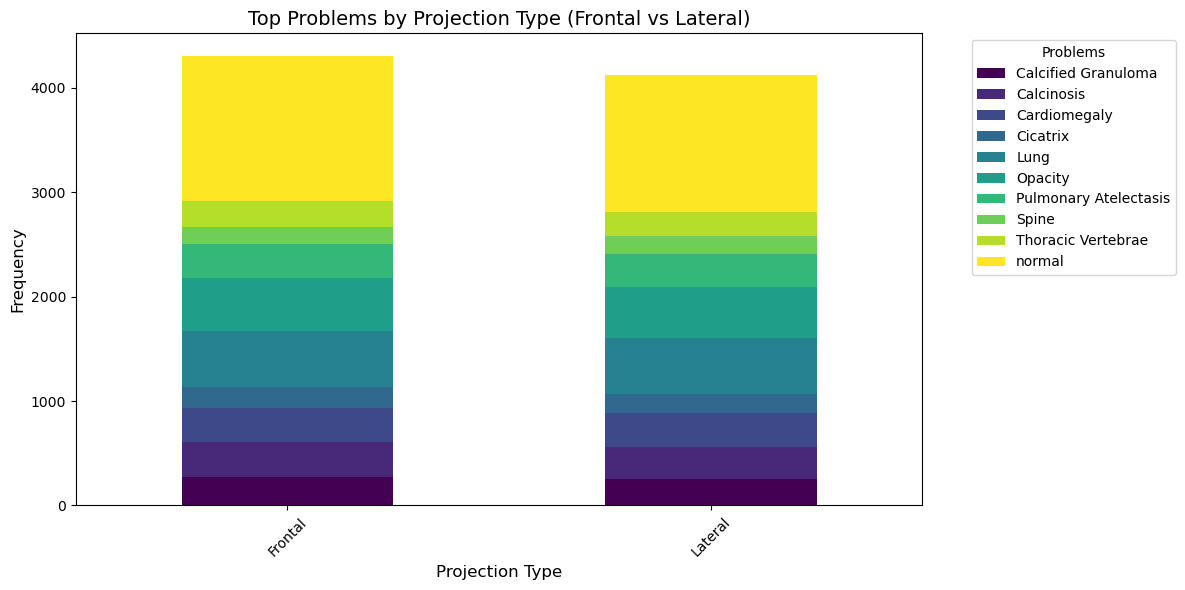

C:\Users\PC\AppData\Local\Temp\ipykernel_5852\2084938179.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_co_occurrence_df['Count'], y=top_co_occurrence_df['Pair'].astype(str), palette='viridis')


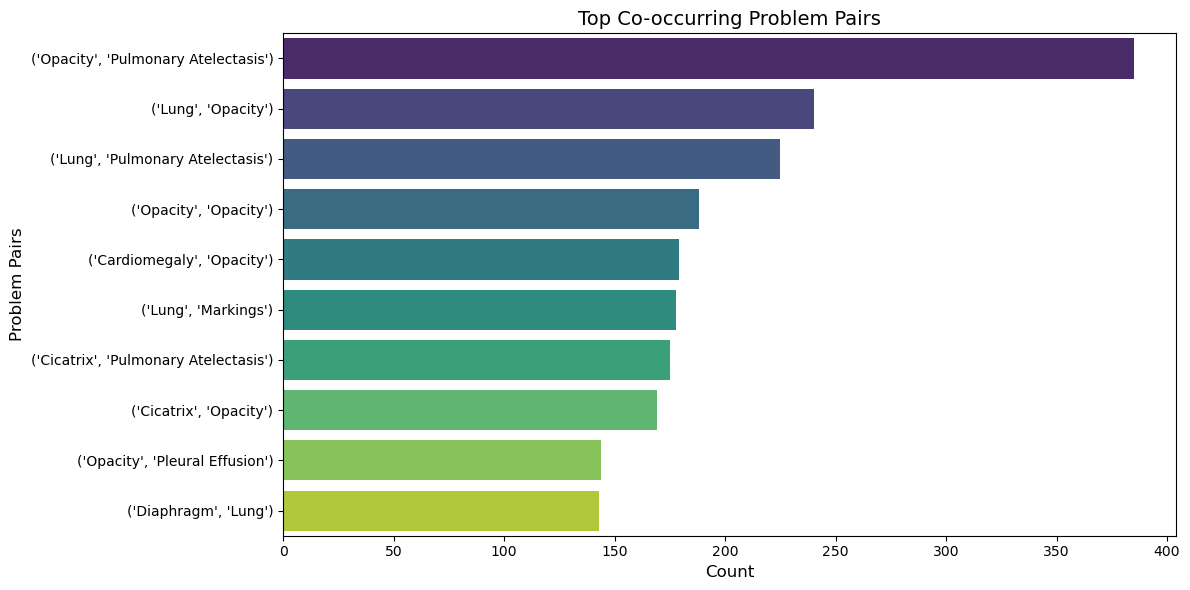

C:\Users\PC\AppData\Local\Temp\ipykernel_5852\2084938179.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=impression_counts.values, y=impression_counts.index, palette='mako')


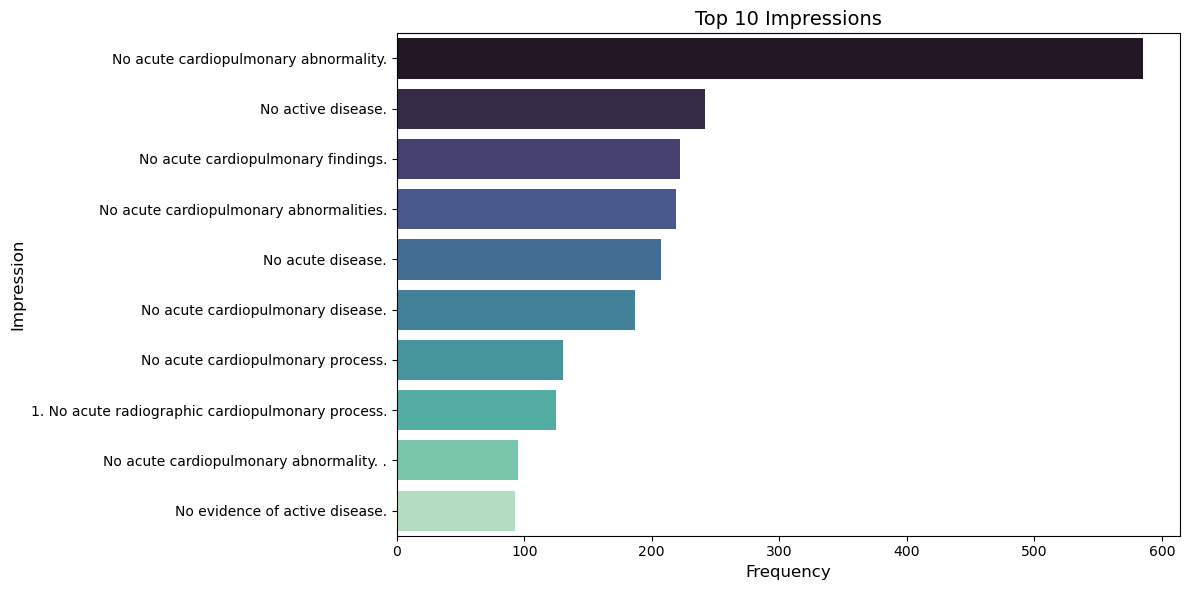

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
top_problems = problems_counts.head(10).index
filtered_df = merged_df[merged_df['Problems'].notnull()]
filtered_df['Problems_list'] = filtered_df['Problems'].str.split(';')

# Extract Frontal and Lateral counts for top problems
problem_projection_counts = filtered_df.explode('Problems_list').query(
    "Problems_list in @top_problems"
).groupby(['projection', 'Problems_list']).size().unstack(fill_value=0)

# Plot top problems by projection type
plt.figure(figsize=(12, 6))
problem_projection_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Top Problems by Projection Type (Frontal vs Lateral)', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Projection Type', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Problems', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




# Co-occurrence analysis of problems
from itertools import combinations
from collections import Counter

# Count co-occurrence of problems
co_occurrence = Counter(
    comb
    for problems in filtered_df['Problems_list']
    for comb in combinations(sorted(problems), 2)
)

# Convert to DataFrame for visualization
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)

# Top co-occurring pairs
top_co_occurrence_df = co_occurrence_df.head(10)

# Plot co-occurrence
plt.figure(figsize=(12, 6))
sns.barplot(x=top_co_occurrence_df['Count'], y=top_co_occurrence_df['Pair'].astype(str), palette='viridis')
plt.title('Top Co-occurring Problem Pairs', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Problem Pairs', fontsize=12)
plt.tight_layout()
plt.show()





# Analyze top impressions
impression_counts = merged_df['impression'].value_counts().head(10)

# Plot impressions
plt.figure(figsize=(12, 6))
sns.barplot(x=impression_counts.values, y=impression_counts.index, palette='mako')
plt.title('Top 10 Impressions', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Impression', fontsize=12)
plt.tight_layout()
plt.show()


-----------------------------------------------------------------------------------------------------------
# 분석결과:
## 투영 방식별 주요 문제 분포:
#### rontal과 Lateral 모두에서 공통적으로 많이 나타나는 문제는 normal, Lung, Opacity 등입니다.
#### 일부 문제는 특정 투영 방식에서 더 자주 나타나는 경향이 보입니다.

## 문제의 상관관계 분석:
#### 자주 함께 발견되는 문제 쌍의 상위 10개를 분석한 결과, 특정 문제들이 서로 연관되어 발생하는 경향이 있습니다.
#### 예: Lung과 Opacity의 빈도가 2번째로 높습니다.

## 최종 진단(Impression) 빈도:
#### 상위 10개의 진단 결과 중 대부분이 "정상"에 해당하거나 경미한 소견을 나타냅니다.
#### 이는 주로 "Normal chest x-ray"와 같은 진단이 빈번하다는 점을 보여줍니다.

-----------------------------------------------------------------------------------------------------------
## 1-4. 각 항목(column)의데이터 유형별 주요 통계
#### 카테고리형 데이터의 분포와 결측치를 포함한 데이터 품질을 확인

In [17]:
# Analyze each column in the merged dataset

def analyze_column(df):
    column_analysis = {}
    for column in df.columns:
        col_data = df[column]
        if col_data.dtype == 'object':
            # Categorical data analysis
            column_analysis[column] = {
                'Type': 'Categorical',
                'Unique Values': col_data.nunique(),
                'Most Common': col_data.value_counts().head(1).to_dict(),
                'Missing Values': col_data.isnull().sum(),
            }
        else:
            # Numerical data analysis
            column_analysis[column] = {
                'Type': 'Numerical',
                'Mean': col_data.mean(),
                'Median': col_data.median(),
                'Standard Deviation': col_data.std(),
                'Missing Values': col_data.isnull().sum(),
            }
    return column_analysis

# Perform analysis on the merged DataFrame
column_analysis_results = analyze_column(merged_df)
column_analysis_results


{'uid': {'Type': 'Numerical',
  'Mean': 2002.8941869809805,
  'Median': 1999.0,
  'Standard Deviation': 1159.4883664169997,
  'Missing Values': 0},
 'filename': {'Type': 'Categorical',
  'Unique Values': 7466,
  'Most Common': {'1_IM-0001-4001.dcm.png': 1},
  'Missing Values': 0},
 'projection': {'Type': 'Categorical',
  'Unique Values': 2,
  'Most Common': {'Frontal': 3818},
  'Missing Values': 0},
 'MeSH': {'Type': 'Categorical',
  'Unique Values': 1900,
  'Most Common': {'normal': 2695},
  'Missing Values': 0},
 'Problems': {'Type': 'Categorical',
  'Unique Values': 1432,
  'Most Common': {'normal': 2695},
  'Missing Values': 0},
 'image': {'Type': 'Categorical',
  'Unique Values': 697,
  'Most Common': {'Xray Chest PA and Lateral': 2363},
  'Missing Values': 0},
 'indication': {'Type': 'Categorical',
  'Unique Values': 2454,
  'Most Common': {'Chest pain': 253},
  'Missing Values': 159},
 'comparison': {'Type': 'Categorical',
  'Unique Values': 393,
  'Most Common': {'None.': 1589}

# 분석결과:


## uid (Numerical)
#### -유형: 숫자형
#### -평균: 2002.89
#### -중앙값: 1999.0 (중앙값이 평균보다 약간 낮아 데이터가 약간 오른쪽으로 치우친 경향)
#### -표준편차: 1159.49 (데이터가 크게 분산됨)
#### -결측값: 없음
## 2. filename (Categorical)
#### 유형: 범주형
#### -고유 값 개수: 7466 (각 파일 이름은 고유)
#### -가장 빈도가 높은 값: '1_IM-0001-4001.dcm.png' (1회 나타남)
#### -결측값: 없음
## 3. projection (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 2 (Frontal, Lateral)
#### -가장 빈도가 높은 값: 'Frontal' (3818회 나타남)
#### -결측값: 없음
## 4. MeSH (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 1900
#### -가장 빈도가 높은 값: 'normal' (2695회 나타남)
#### -결측값: 없음
## 5. Problems (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 1432
#### -가장 빈도가 높은 값: 'normal' (2695회 나타남)
#### -결측값: 없음
## 6. image (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 697
#### -가장 빈도가 높은 값: 'Xray Chest PA and Lateral' (2363회 나타남)
#### -결측값: 없음
## 7. indication (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 2454
#### -가장 빈도가 높은 값: 'Chest pain' (253회 나타남)
#### -결측값: 159
## 8. comparison (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 393
#### -가장 빈도가 높은 값: 'None.' (1589회 나타남)
#### -결측값: 2260 (많은 결측값이 존재)
## 9. findings (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 2553
#### -가장 빈도가 높은 값: 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.' (98회 나타남)
#### -결측값: 997
## 10. impression (Categorical)
#### -유형: 범주형
#### -고유 값 개수: 1770
#### -가장 빈도가 높은 값: 'No acute cardiopulmonary abnormality.' (585회 나타남)
#### -결측값: 52